In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import json
import requests
from pprint import pprint
from collections import Counter

In [2]:
data_dir = "/Users/ak/tte/data/sample-data/gsm"

basline_dir = data_dir + "/baseline_pass_20_ckpt_200" 
s3c_dir = data_dir + "/s3c_trace_pass_20_ckpt_1000" 


basline_json_file_path = basline_dir + "/predict_predictions.json"
basline_stat_log_path = basline_dir + "/predict_results.json"

s3c_json_file_path = s3c_dir + "/predict_predictions.json"
s3c_stat_log_path = s3c_dir + "/predict_results.json"

In [3]:
basline_stat_log_data = pd.read_json(basline_stat_log_path, typ='series')
basline_stat_log_dict = basline_stat_log_data.to_dict()

s3c_stat_log_data = pd.read_json(s3c_stat_log_path, typ='series')
s3c_stat_log_dict = s3c_stat_log_data.to_dict()

### Basline gsm pass@20 vs s3c round 0 pass@20

In [4]:
print(f" Basline: {basline_stat_log_dict['test_raw_pass@20']}% | s3c: {s3c_stat_log_dict['test_round_0_estimated_pass@20']}%")

 Basline: 43.5178% | s3c: 36.8461%


In [5]:
basline_json = pd.read_json(basline_json_file_path)
baseline_dict = basline_json.to_dict()

In [6]:
s3c_json = pd.read_json(s3c_json_file_path)
s3c_dict = s3c_json.to_dict()

In [7]:
def get_clusters(generated_programs_dict):

    clusters_dict = {}
    clusters_list = []
    
    for prompt in generated_programs_dict:
        i = 0

        programs_list = []
        while i < len(generated_programs_dict[prompt]):
            programs_list.append( generated_programs_dict[prompt][i]['generated_program'])
            i+=1

        counts = Counter(programs_list)
        
        for cluster in counts:
            indices = [i for i in range(len(generated_programs_dict[prompt])) if programs_list[i] == cluster]
            clusters_list.append(indices)
        clusters_dict.update({prompt:clusters_list})
        clusters_list = []

    return clusters_dict

In [8]:
basline_clusters_dict = get_clusters(baseline_dict)
s3c_clusters_dict = get_clusters(s3c_dict)

In [9]:
def filter_failed_prompts(baseline_dict):
    count = 0 
    
    failed_list = []
        
    for prompt in baseline_dict:
        fail_state = True
        for output in baseline_dict[prompt]:
            if(baseline_dict[prompt][output]['compiler_output'][0] == True):
                fail_state = False
                break
        if fail_state:
            failed_list.append(prompt)
        

    return(failed_list)

In [10]:
def filter_passing_prompts(s3c_dict):
    count = 0 
    
    passed_list = []
        
    for prompt in s3c_dict:
        success_state = False
        for output in s3c_dict[prompt]:
            if(s3c_dict[prompt][output]['compiler_output'][0] == True):
                success_state = True
                break
        if success_state:
            passed_list.append(prompt)
        

    return(passed_list)

In [11]:
def filter_clusters(generated_programs_dict, clusters_dict, correct_only = None, cluster_size_range = (1,5)):
    count = 0 
    
    filtered_dict = {}
    
    for cluster_id in clusters_dict:
        # if count == 23: break #Debug early stopping
        # count+=1

        filtered_clusters_list = []
        
        for cluster in clusters_dict[cluster_id]:
            if (cluster_size_range[0] <= (len(clusters_dict[cluster_id])) <= cluster_size_range[1]):
                if correct_only == True:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == True):
                        filtered_clusters_list.append(cluster)
                elif correct_only == False:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == False):
                        #print(cluster_id, cluster[0])
                        filtered_clusters_list.append(cluster)
                else:
                    filtered_clusters_list.append(cluster)
                    
        if(len(filtered_clusters_list) > 0): filtered_dict.update({cluster_id:filtered_clusters_list})

    return(filtered_dict)

In [12]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))

In [13]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [14]:
#pprint(filter_failed_prompts(baseline_dict))
#pprint(filter_passing_prompts(s3c_dict))

tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

print( len(tf_intersection) )
print( tf_intersection )

156
['test_411', 'test_1114', 'test_877', 'test_731', 'test_1315', 'test_147', 'test_978', 'test_158', 'test_88', 'test_1272', 'test_1036', 'test_867', 'test_615', 'test_1050', 'test_668', 'test_994', 'test_1026', 'test_891', 'test_557', 'test_1047', 'test_44', 'test_348', 'test_768', 'test_922', 'test_438', 'test_129', 'test_1066', 'test_637', 'test_791', 'test_649', 'test_852', 'test_774', 'test_1053', 'test_707', 'test_745', 'test_1318', 'test_1', 'test_375', 'test_1141', 'test_263', 'test_1121', 'test_1014', 'test_1164', 'test_7', 'test_1041', 'test_94', 'test_798', 'test_644', 'test_987', 'test_710', 'test_231', 'test_682', 'test_508', 'test_743', 'test_596', 'test_622', 'test_1083', 'test_523', 'test_31', 'test_60', 'test_95', 'test_311', 'test_929', 'test_289', 'test_597', 'test_829', 'test_857', 'test_194', 'test_848', 'test_27', 'test_673', 'test_900', 'test_53', 'test_1249', 'test_960', 'test_146', 'test_39', 'test_583', 'test_704', 'test_779', 'test_442', 'test_562', 'test_9

In [15]:
reversed_tf_intersection = intersection(filter_failed_prompts(s3c_dict), filter_passing_prompts(baseline_dict))
print(len(reversed_tf_intersection))
print(reversed_tf_intersection)

186
['test_519', 'test_575', 'test_652', 'test_1208', 'test_412', 'test_253', 'test_1081', 'test_247', 'test_1279', 'test_397', 'test_654', 'test_1125', 'test_1261', 'test_16', 'test_862', 'test_386', 'test_670', 'test_471', 'test_735', 'test_1198', 'test_773', 'test_1187', 'test_1170', 'test_125', 'test_284', 'test_883', 'test_1167', 'test_485', 'test_1200', 'test_499', 'test_653', 'test_89', 'test_279', 'test_145', 'test_506', 'test_609', 'test_927', 'test_1104', 'test_930', 'test_350', 'test_19', 'test_1134', 'test_800', 'test_684', 'test_1227', 'test_446', 'test_118', 'test_460', 'test_753', 'test_1221', 'test_759', 'test_166', 'test_1177', 'test_837', 'test_0', 'test_522', 'test_137', 'test_1064', 'test_170', 'test_136', 'test_1058', 'test_1078', 'test_807', 'test_959', 'test_836', 'test_1248', 'test_1115', 'test_142', 'test_447', 'test_489', 'test_697', 'test_892', 'test_1042', 'test_450', 'test_801', 'test_319', 'test_406', 'test_1233', 'test_809', 'test_628', 'test_68', 'test_1

In [16]:
len(filter_failed_prompts(baseline_dict)), len(filter_failed_prompts(s3c_dict))

(745, 775)

In [17]:
len( intersection(filter_failed_prompts(s3c_dict), filter_failed_prompts(baseline_dict)) )

589

In [18]:
len(filter_passing_prompts(baseline_dict)), len(filter_passing_prompts(s3c_dict))

(574, 544)

In [19]:
print(30/1300)

0.023076923076923078


In [20]:
len(baseline_dict), len(s3c_dict)

(1319, 1319)

In [21]:
basline_clusters_dict['test_743']

[[0, 7, 13, 17, 18],
 [1, 2, 4, 5, 6, 8, 11, 14, 15],
 [3],
 [9, 10],
 [12],
 [16],
 [19]]

In [22]:
tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

In [23]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))
correct_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, True, (1, 20))

In [24]:
pprint(baseline_dict['test_1272'][0]['prompt'])

('QUESTION:\n'
 'Helen went on a trip through Germany. She booked a hotel for 3 nights and '
 'rode the bus 7 times during that trip. One night at the hotel was a cost of '
 '$80, and every bus trip was 10% of the price of one night at the hotel. How '
 'much did Helen pay for the hotel and bus travels during that trip?\n'
 'ANSWER:\n')


In [25]:
def get_longest(lst):
    return max(lst, key=len)

def find_overlap( tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters, false_to_true = True): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])
        
        if false_to_true:
            basline_msg = "Incorrect Baseline Generation: \n"
            s3c_msg = "Correct S3C Generation: \n"
            
        else:
            basline_msg = "Correct Baseline Generation: \n"
            s3c_msg = "Incorrect S3C Generation: \n"            
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                print( f"Prompt: {prompt} \n")
                print(f"Count: {count}")
                count+=1
                print(basline_msg)
                print( baseline_dict[prompt][basline_cluster[0]]['generated_program'] )

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_b}") 

                print("----------------------------------------------------------------")

                print(s3c_msg)
                print( s3c_dict[prompt][s3c_cluster[0]]['generated_program'] )

                #gt_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['expected_answer']
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_s3}") 
                print("----------------------------------------------------------------")
                
                print("Ground Truth Program: \n")
                print( baseline_dict[prompt][0]['ground_truth_program'] )
                print(f"Ground Truth Answer: {gt_ans}") 
                
                print("----------------------------------------------------------------")
                print("Notes: ")
                print("|=================================================================================================================================|\n")
        

In [26]:
#find_overlap(tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters) #Print cases where basline solved the prompt incorrect and s3c solved it correctly

In [27]:
correct_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, True, (1, 20))
incorrect_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, False, (1, 20))

In [28]:
ft_intersection = intersection(filter_passing_prompts(baseline_dict), filter_failed_prompts(s3c_dict))

In [29]:
print(ft_intersection)

['test_519', 'test_575', 'test_652', 'test_1208', 'test_412', 'test_253', 'test_1081', 'test_247', 'test_1279', 'test_397', 'test_654', 'test_1125', 'test_1261', 'test_16', 'test_862', 'test_386', 'test_670', 'test_471', 'test_735', 'test_1198', 'test_773', 'test_1187', 'test_1170', 'test_125', 'test_284', 'test_883', 'test_1167', 'test_485', 'test_1200', 'test_499', 'test_653', 'test_89', 'test_279', 'test_145', 'test_506', 'test_609', 'test_927', 'test_1104', 'test_930', 'test_350', 'test_19', 'test_1134', 'test_800', 'test_684', 'test_1227', 'test_446', 'test_118', 'test_460', 'test_753', 'test_1221', 'test_759', 'test_166', 'test_1177', 'test_837', 'test_0', 'test_522', 'test_137', 'test_1064', 'test_170', 'test_136', 'test_1058', 'test_1078', 'test_807', 'test_959', 'test_836', 'test_1248', 'test_1115', 'test_142', 'test_447', 'test_489', 'test_697', 'test_892', 'test_1042', 'test_450', 'test_801', 'test_319', 'test_406', 'test_1233', 'test_809', 'test_628', 'test_68', 'test_1293'

In [30]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables, values, operators, and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()
    values = {}

    lines = string.strip().split("\n")
    for idx, line in enumerate(lines):
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            # Find dependencies and operators using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            operators = re.findall(r"([\*+/-])", expr)
            
            for i, op in enumerate(operators):
                op_node = f"{idx}:({op})"
                # add edges for operands and operations
                graph.add_edge(dependencies[i], op_node)
                graph.add_edge(dependencies[i+1], op_node)
                graph.add_edge(op_node, var)
                
                # calculate the value
                if op == '*':
                    values[var] = values[dependencies[i]] * values[dependencies[i+1]]
                elif op == '+':
                    values[var] = values[dependencies[i]] + values[dependencies[i+1]]
                elif op == '-':
                    values[var] = values[dependencies[i]] - values[dependencies[i+1]]
                elif op == '/':
                    values[var] = values[dependencies[i]] / values[dependencies[i+1]]

            # If no operator is found, then it's a direct assignment
 if not operators:
        # Check if the expression can be converted to an integer
        try:
            value = int(expr)
        except ValueError:
            # If not, it's a floating-point value
            value = float(expr)
        values[var] = value
        graph.add_node(var, value=values[var])
            else:
                graph.add_node(var, value=values[var])

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# # Create the graph for the input string
# baseline_graph = parse_string_to_graph(correct_string)
# s3c_graph = parse_string_to_graph(incorrect_string)

# Create label mapping
# baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
# s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}

In [31]:
# Function to set variable values and operators as attributes and labels in the graph nodes
def set_node_attributes(graph, var_values, operator_values):
    for node, data in graph.nodes(data=True):
        if "value" in data:
            value = data["value"]
            data["label"] = f"{node}:{value}"
            data["color"] = "red" if node in var_values and var_values[node] != value else "lightblue"
        elif "expression" in data:
            expression = data["expression"]
            data["label"] = expression
            data["color"] = "red" if node in operator_values and operator_values[node] != expression else "lightblue"
        else:
            data["label"] = node
            data["color"] = "lightblue"

In [45]:
def display_graphs(correct_string, incorrect_string):
    # Create the graph for the input string
    baseline_graph = parse_string_to_graph(correct_string)
    s3c_graph = parse_string_to_graph(incorrect_string)

    # Create label mapping
    baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
    s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}    
    
    # Create a subgraph isomorphism matcher
    matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

    # Find all subgraph isomorphisms (common patterns)
    subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

    # Find the nodes with the same variable names in both graphs
    shared_variable_nodes = set(baseline_graph.nodes()) & set(s3c_graph.nodes())

    # Get the variable values for each graph
    var_values_baseline = nx.get_node_attributes(baseline_graph, "value")
    var_values_s3c = nx.get_node_attributes(s3c_graph, "value")

    # Identify nodes with different values between the graphs
    different_value_nodes = {node for node in shared_variable_nodes if var_values_baseline.get(node) != var_values_s3c.get(node)}

    # Get the expressions for each graph
    expressions_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
    expressions_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}

    # Identify nodes with different expressions between the graphs
    different_expression_nodes = {node for node in shared_variable_nodes if expressions_baseline.get(node) != expressions_s3c.get(node)}

    # Set node attributes and labels for visualization
    set_node_attributes(baseline_graph, var_values_baseline, expressions_baseline)
    set_node_attributes(s3c_graph, var_values_s3c, expressions_s3c)


    # Compare the operators between the graphs
    operator_values_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
    operator_values_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}
    different_operator_nodes = {node for node in set(operator_values_baseline) & set(operator_values_s3c) if operator_values_baseline[node] != operator_values_s3c[node]}

    # Find the nodes and edges that are unique to each graph
    unique_nodes_baseline = set(node for node in baseline_graph.nodes() if node not in s3c_graph.nodes() or (node in shared_variable_nodes and var_values_baseline.get(node) != var_values_s3c.get(node)))
    unique_nodes_s3c = set(node for node in s3c_graph.nodes() if node not in baseline_graph.nodes() or (node in shared_variable_nodes and var_values_s3c.get(node) != var_values_baseline.get(node)))

    unique_edges_baseline = set((u, v) for u, v, data in baseline_graph.edges(data=True) if (u, v) not in s3c_graph.edges() and data.get("operator") is None)
    unique_edges_s3c = set((u, v) for u, v, data in s3c_graph.edges(data=True) if (u, v) not in baseline_graph.edges() and data.get("operator") is None)

    # Create a new figure and axis for drawing the graphs
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Draw the baseline graph
    axes[0].set_title("Correct Baseline Generation")
    pos_baseline = nx.spring_layout(baseline_graph, seed=42)
    labels_baseline = nx.get_node_attributes(baseline_graph, "label")
    colors_baseline = nx.get_node_attributes(baseline_graph, "color")
    nx.draw(baseline_graph, pos=pos_baseline, labels=labels_baseline, node_color=list(colors_baseline.values()), node_size=500, font_size=10, ax=axes[0])

    # Draw the s3c graph
    axes[1].set_title("Incorrect S3C Generation")
    pos_s3c = nx.spring_layout(s3c_graph, seed=42)
    labels_s3c = nx.get_node_attributes(s3c_graph, "label")
    colors_s3c = nx.get_node_attributes(s3c_graph, "color")
    nx.draw(s3c_graph, pos=pos_s3c, labels=labels_s3c, node_color=list(colors_s3c.values()), node_size=500, font_size=10, ax=axes[1])

    # Highlight nodes with different values between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_value_nodes, node_color="red", node_size=500, ax=axes[1])

    # Highlight nodes with different expressions between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_expression_nodes, node_color="red", node_size=500, ax=axes[1])


    # Highlight nodes with different operators between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=unique_nodes_s3c, node_color="pink", node_size=500, ax=axes[1])

    plt.tight_layout()
    plt.show()

    # Print the unique nodes and edges in each graph
    print("Unique nodes in Baseline Graph:", unique_nodes_baseline)
    print("Unique nodes in S3C Graph:", unique_nodes_s3c)

    print("Unique edges in Baseline Graph:", unique_edges_baseline)
    print("Unique edges in S3C Graph:", unique_edges_s3c)


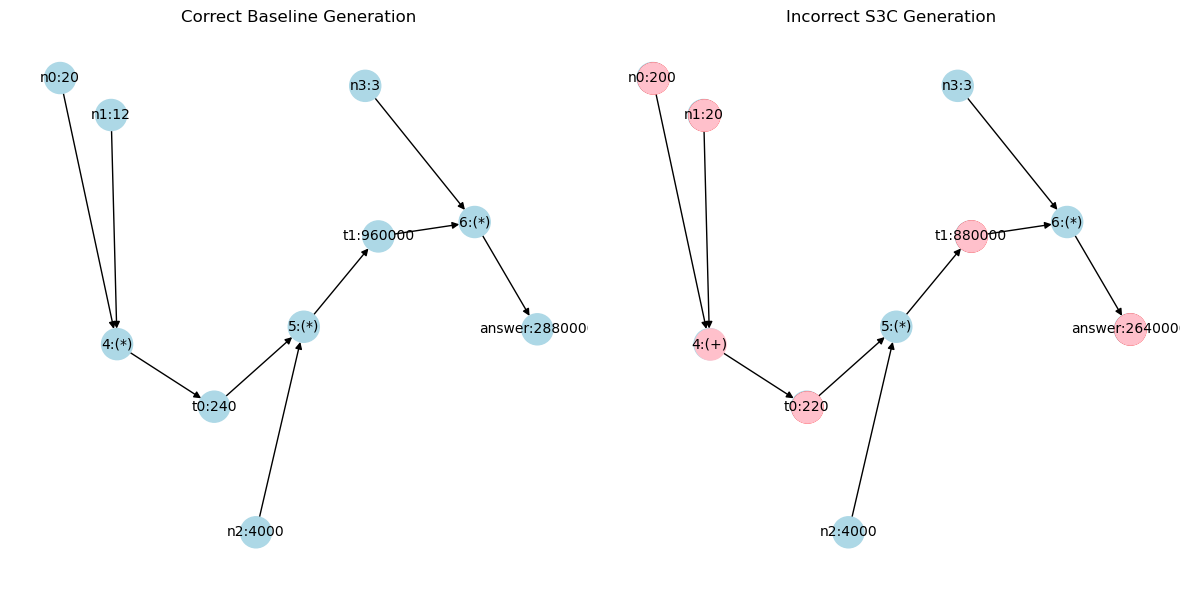

Unique nodes in Baseline Graph: {'t0', 'answer', 'n1', 'n0', '4:(*)', 't1'}
Unique nodes in S3C Graph: {'4:(+)', 't0', 'answer', 'n1', 'n0', 't1'}
Unique edges in Baseline Graph: {('4:(*)', 't0'), ('n0', '4:(*)'), ('n1', '4:(*)')}
Unique edges in S3C Graph: {('n0', '4:(+)'), ('4:(+)', 't0'), ('n1', '4:(+)')}


In [46]:
display_graphs(correct_string, incorrect_string)

In [47]:
def print_graph_comparisons(tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])    
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                
                basline_program = baseline_dict[prompt][basline_cluster[0]]['generated_program']
                s3c_program = s3c_dict[prompt][s3c_cluster[0]]['generated_program']
                
                display_graphs(basline_program, s3c_program)

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"Basline Generated Answer: {gen_ans_b}, S3C Generated Answer: {gen_ans_s3}, GT Answer {gt_ans}") 
                
                print("----------------------------------------------------------------")

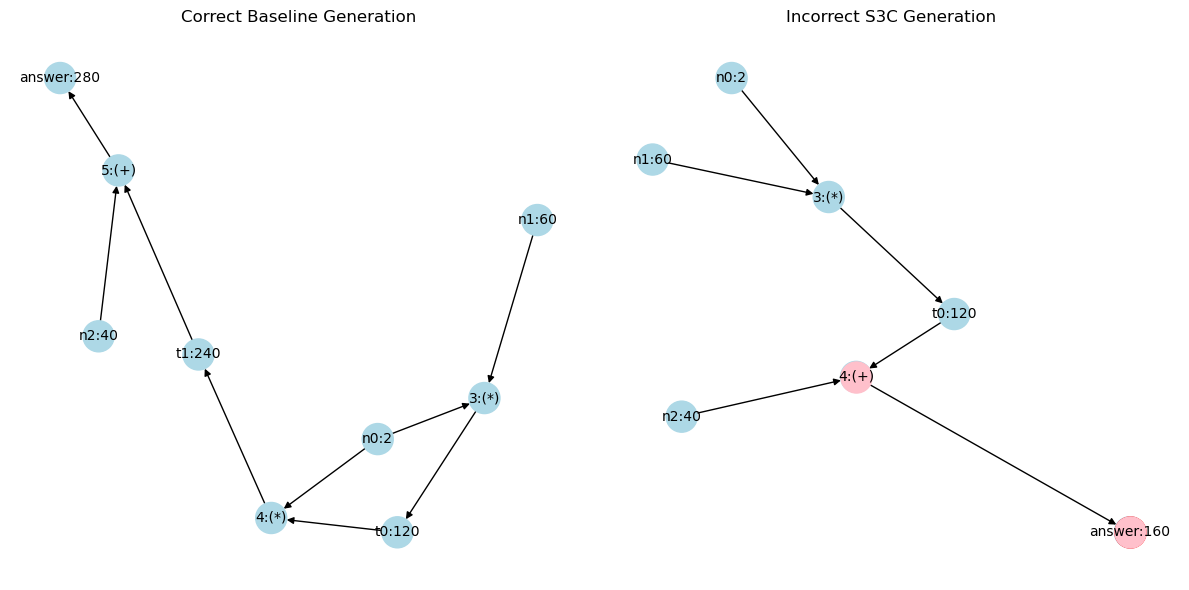

Unique nodes in Baseline Graph: {'answer', '5:(+)', 't1', '4:(*)'}
Unique nodes in S3C Graph: {'4:(+)', 'answer'}
Unique edges in Baseline Graph: {('t1', '5:(+)'), ('5:(+)', 'answer'), ('n0', '4:(*)'), ('4:(*)', 't1'), ('t0', '4:(*)'), ('n2', '5:(+)')}
Unique edges in S3C Graph: {('4:(+)', 'answer'), ('n2', '4:(+)'), ('t0', '4:(+)')}
Basline Generated Answer: 280, S3C Generated Answer: 160, GT Answer 280.0
----------------------------------------------------------------


ValueError: invalid literal for int() with base 10: '1.5'

In [48]:
print_graph_comparisons(ft_intersection, baseline_dict, s3c_dict, correct_baseline_clusters, incorrect_s3c_clusters)